In [1]:
import os
import pandas as pd
import string
import random
import matplotlib
import numpy as np
import coremltools
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from keras import backend as K
from ast import literal_eval
from sklearn.utils import class_weight
from keras.models import Sequential
from keras.models import load_model
from keras.metrics import top_k_categorical_accuracy
from keras.callbacks import ModelCheckpoint
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, LeakyReLU
from keras import regularizers, optimizers
from livelossplot import PlotLossesKeras
from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from PIL import ImageFile, Image


In [2]:
DATASET_PATH = "MAFood121\\images\\"
METADATA_PATH = "MAFood121\\metadata_win.csv"
IMAGE_PATH_KEY = "image_path"
LABELS_PATH_KEY = "label"
MODEL_PATH = "food-id-red23.h5"
IMAGE_SIZE = 224
BATCH_SIZE = 32
RANDOM_SEED = 115
EPOCHS = 50
TESTING_SIZE = 500
VALIDATION_SPLIT = 0.1
LEARNING_RATE = 0.0001
LEARNING_RATE_DECAY = LEARNING_RATE/100.0
CONFIDENCE_THRESHOLD = 0.9
ImageFile.LOAD_TRUNCATED_IMAGES = True
Image.MAX_IMAGE_PIXELS = 239200489

In [3]:
# Loading metadata and splitting into training/validation and testing sets
df = pd.read_csv(METADATA_PATH)

training_and_validation_size = df.shape[0] - TESTING_SIZE

training_df = df[:training_and_validation_size]
testing_df = df[training_and_validation_size:]

training_df[LABELS_PATH_KEY] = training_df[LABELS_PATH_KEY].apply(lambda x:literal_eval(x))
training_df

<ipython-input-3-9f420f2a59a6>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_df[LABELS_PATH_KEY] = training_df[LABELS_PATH_KEY].apply(lambda x:literal_eval(x))


,image_path,label
0,hunkar_begendi\240.jpg,[hunkar_begendi]
1,hunkar_begendi\21.jpg,[hunkar_begendi]
2,naan\49_1.jpg,[naan]
3,ravioli\2725271.jpg,[ravioli]
4,caprese_salad\2358715.jpg,[caprese_salad]
...,...,...
20670,souvlaki\85_2.jpg,[souvlaki]
20671,breakfast_burrito\805523.jpg,[breakfast_burrito]
20672,nachos\500252.jpg,[nachos]
20673,omelette\800743.jpg,[omelette]


In [4]:
# Getting labels
all_labels = [] 

for tags in training_df[LABELS_PATH_KEY].values.tolist():
    for tag in tags:
        all_labels.append(tag)
        
unique_labels = list(np.unique(all_labels))

In [5]:
training_data_generator = ImageDataGenerator(rotation_range=15,
                                             zoom_range=0.1,
                                             width_shift_range=0.1,
                                             height_shift_range=0.1,
                                             shear_range=0.1,
                                             horizontal_flip=False,
                                             fill_mode="nearest",
                                             validation_split=VALIDATION_SPLIT,
                                             preprocessing_function=preprocess_input)

training_generator = training_data_generator.flow_from_dataframe(dataframe=training_df,
                                                                 directory=DATASET_PATH,
                                                                 x_col=IMAGE_PATH_KEY, 
                                                                 y_col=LABELS_PATH_KEY,
                                                                 batch_size=BATCH_SIZE,
                                                                 seed=RANDOM_SEED,
                                                                 class_mode="categorical",
                                                                 target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                                 subset="training")

validation_generator = training_data_generator.flow_from_dataframe(dataframe=training_df,
                                                                   directory=DATASET_PATH,
                                                                   x_col=IMAGE_PATH_KEY,
                                                                   y_col=LABELS_PATH_KEY,
                                                                   batch_size=BATCH_SIZE,
                                                                   seed=RANDOM_SEED,
                                                                   class_mode="categorical",
                                                                   target_size=(IMAGE_SIZE, IMAGE_SIZE), 
                                                                   subset="validation")


Found 18608 validated image filenames belonging to 121 classes.
Found 2067 validated image filenames belonging to 121 classes.


In [6]:
def model():
    def model(backbone):
        model = Sequential()
        model.add(backbone)
        model.add(GlobalAveragePooling2D())
        model.add(BatchNormalization())
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.3))
        model.add(Dropout(.5))
        #model.add(Dense(256))
        #model.add(LeakyReLU(alpha=0.3))
        #model.add(Dropout(.5))
        #model.add(Dense(1024, activation='relu'))
        #model.add(Dense(1024, activation='relu'))
        #model.add(Dense(512, activation='relu'))
        
        model.add(Dense(len(unique_labels), activation='softmax'))
        model.compile(loss='categorical_crossentropy',
                      optimizer=optimizers.Adam(lr=LEARNING_RATE, decay=0),
                      metrics=["accuracy"])
        return model

    backbone = MobileNetV2(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')
    backbone.trainable = False
    return model(backbone)


model = model()

In [7]:
# Setting class weights to handle imbalanced data
'''
class_weights = class_weight.compute_class_weight('balanced',
                                                  unique_labels,
                                                  all_labels)

'''
#class_weights = dict(enumerate(class_weights))

"\nclass_weights = class_weight.compute_class_weight('balanced',\n                                                  unique_labels,\n                                                  all_labels)\n\n"

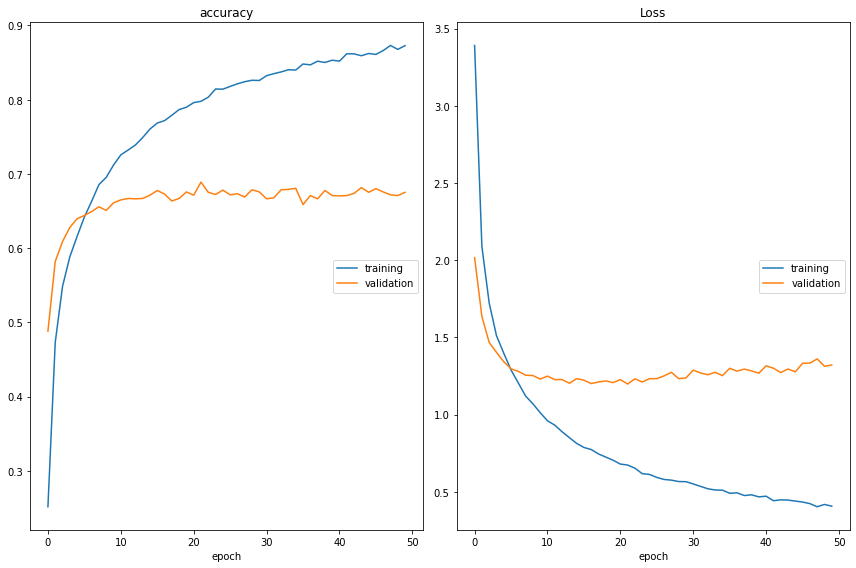

accuracy
	training         	 (min:    0.252, max:    0.873, cur:    0.873)
	validation       	 (min:    0.488, max:    0.689, cur:    0.675)
Loss
	training         	 (min:    0.403, max:    3.391, cur:    0.406)
	validation       	 (min:    1.197, max:    2.016, cur:    1.321)

Epoch 00050: val_accuracy did not improve from 0.68896


In [8]:
# Training
model.fit_generator(generator=training_generator,
                    #class_weight=class_weights,
                    steps_per_epoch=training_generator.n // training_generator.batch_size,
                    validation_data=validation_generator,
                    validation_steps=validation_generator.n // validation_generator.batch_size,
                    callbacks=[PlotLossesKeras(), 
                               ModelCheckpoint(MODEL_PATH,
                                               monitor='val_accuracy',
                                               mode='max',
                                               save_best_only=True,
                                               verbose=1)],
                    epochs=EPOCHS)
model = load_model(MODEL_PATH)

In [9]:
# Testing
testing_data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
testing_generator = testing_data_generator.flow_from_dataframe(dataframe=testing_df,
                                                               directory=DATASET_PATH,
                                                               x_col=IMAGE_PATH_KEY,
                                                               batch_size=1,
                                                               seed=RANDOM_SEED,
                                                               shuffle=False,
                                                               class_mode=None,
                                                               target_size=(IMAGE_SIZE, IMAGE_SIZE))
predictions = model.predict_generator(testing_generator,
                                      steps=testing_generator.n,
                                      verbose=1)

Found 500 validated image filenames.


c:\users\eric_\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\keras\engine\training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


500/500 [==============================] - 8s 15ms/step


In [10]:
for prediction in predictions:
    print(prediction)

[2.22170293e-05 1.81061290e-02 7.33691500e-04 9.30272108e-06
 1.73734752e-05 2.34051682e-02 3.00319046e-01 2.57978991e-05
 3.75461752e-07 1.98486050e-05 2.97505438e-04 1.66483708e-02
 4.52416978e-04 5.01950504e-03 4.12632432e-03 7.18739349e-04
 4.80799424e-03 1.27538119e-03 4.89758253e-02 1.62016352e-06
 8.42657537e-05 2.32346010e-05 3.31969823e-05 9.21931758e-04
 1.41721583e-04 9.19649847e-06 1.55819347e-03 4.16506919e-05
 3.03079403e-04 9.83301084e-03 2.25462904e-03 1.58502138e-04
 1.64061839e-05 2.29031313e-04 1.37946641e-04 2.37929493e-01
 2.12101531e-05 3.59180194e-05 1.10951932e-02 1.45220365e-02
 1.37058944e-02 7.13431102e-04 1.25955734e-02 2.99114367e-06
 6.97230871e-06 9.33477277e-05 4.39873673e-07 8.81230750e-04
 7.44950512e-06 4.85272867e-05 2.32037564e-05 1.69021382e-06
 3.88663739e-06 6.44042473e-07 3.64408916e-04 4.01636178e-04
 5.04138297e-05 9.12971791e-06 1.10773426e-05 3.58343171e-03
 9.40340251e-05 4.78917646e-05 3.13671335e-04 5.68196410e-04
 1.38904568e-07 5.131910

 1.5869064e-05]
[7.81426497e-04 1.58124135e-06 2.80982815e-03 3.70570109e-03
 1.12465864e-06 8.08397457e-02 4.17822521e-05 3.48963193e-04
 1.19432207e-05 1.17045583e-03 7.65842909e-04 2.15428695e-02
 1.23408145e-05 7.66150141e-03 3.37448569e-06 9.38805286e-04
 9.54999472e-04 1.07080704e-02 1.50447318e-04 1.20574459e-05
 2.50170342e-05 9.18375049e-03 1.39245691e-04 3.85028688e-04
 7.43421586e-03 6.78106269e-04 6.28866628e-02 1.29002414e-03
 4.27629380e-03 1.71132025e-03 1.97176880e-04 1.24476910e-05
 9.43121559e-05 4.00004274e-06 1.26979085e-05 6.45576976e-03
 9.95690357e-07 5.86390797e-06 2.31470840e-04 5.97816950e-04
 1.73232991e-06 4.24992595e-06 4.76745481e-06 1.36391549e-07
 2.60293223e-06 3.82854637e-07 1.00797797e-02 4.08235137e-05
 3.97739059e-04 7.11505709e-05 2.65579620e-05 6.34707831e-05
 2.89217314e-06 9.35001935e-06 2.43647806e-02 4.55617963e-04
 6.22612242e-06 2.24085798e-05 6.20516767e-06 1.41117489e-03
 6.70642112e-05 1.03037795e-02 2.15246808e-04 1.37958123e-05
 6.83827

 1.3599387e-10]
[5.32775560e-11 1.39262909e-07 9.12700273e-07 4.18480965e-08
 1.63400848e-10 1.48219297e-05 2.57225796e-08 3.61284364e-10
 1.32121580e-09 1.52473845e-09 4.16438319e-02 1.34859292e-04
 1.08663922e-08 1.01943106e-05 1.32826435e-05 3.50957521e-08
 3.08946454e-07 2.97832339e-05 4.39667133e-07 9.52937305e-01
 1.11159011e-07 1.04358082e-06 4.02124670e-06 4.85339491e-10
 1.81378967e-09 1.07646838e-06 3.81576901e-05 1.84097502e-04
 2.47910563e-08 2.31603707e-07 8.27309208e-08 8.49418100e-08
 1.20678254e-04 3.99651640e-07 7.64959914e-05 1.61855685e-04
 1.75766068e-08 5.54998962e-07 9.69977094e-08 3.38469886e-06
 1.09724239e-08 1.89190575e-06 3.86228777e-07 6.55433041e-06
 7.56405484e-07 4.64346472e-09 8.71037097e-12 2.54469512e-09
 4.23675406e-09 4.31916325e-09 5.65944320e-05 3.57603014e-09
 4.51554003e-11 4.01676175e-12 8.39467162e-09 1.50416335e-09
 4.88692109e-09 4.23765502e-11 6.77980267e-08 2.67288258e-09
 2.26146512e-05 2.83605388e-08 2.47331081e-06 5.00507383e-07
 6.29379

 1.4439977e-06]
[4.52048698e-04 1.09333843e-04 8.25961868e-11 2.27777708e-09
 3.92414267e-06 3.26684769e-03 5.04181371e-04 1.83894254e-11
 1.77483354e-03 3.52312827e-06 6.96104398e-05 4.19123035e-06
 3.54654709e-04 5.37732581e-10 3.77988363e-06 5.76181264e-07
 1.85107754e-03 5.85948401e-05 1.11621216e-06 3.43070606e-05
 1.74107527e-06 3.47253517e-04 5.12301446e-09 9.70605707e-10
 3.74956377e-04 6.51274490e-07 6.72749366e-06 2.48475889e-08
 6.74038301e-06 1.53204994e-04 2.03349249e-09 1.84293867e-07
 9.47507601e-07 3.01197142e-04 1.27382451e-08 5.34739684e-07
 4.97377306e-10 5.48977808e-10 2.62505431e-08 7.82965799e-08
 2.97490199e-10 1.02375424e-03 1.12342171e-08 2.93493235e-06
 9.50404967e-04 7.49743208e-07 1.91157713e-04 2.93953695e-10
 5.05084818e-09 9.28835959e-08 3.71589907e-04 6.58487994e-03
 5.84919144e-06 6.64085671e-02 9.74672698e-09 6.07456896e-04
 4.63901406e-09 5.40113251e-06 4.67574409e-06 1.33747902e-09
 2.65659810e-06 2.63930611e-09 2.76286646e-05 1.24380382e-08
 2.25939

 2.24618490e-10]
[3.33801232e-04 1.06768729e-03 3.96724026e-05 2.11030873e-03
 1.91353058e-04 4.00662160e-04 3.12388525e-04 7.83263822e-04
 2.66138057e-04 1.68561401e-05 4.53646421e-01 2.98322411e-04
 2.06874490e-01 2.67599680e-04 4.88690974e-04 2.73926824e-04
 4.40104886e-05 7.10354298e-02 1.20414802e-06 7.55896690e-05
 1.64479890e-04 1.23618127e-04 4.00413875e-04 1.49870584e-05
 1.30468374e-03 1.74068828e-06 3.29083705e-05 3.82680027e-03
 4.03532213e-05 1.70761477e-02 5.27009397e-05 4.62888529e-05
 7.08101597e-03 1.24891794e-05 4.89673912e-05 5.66194976e-05
 3.65255391e-06 3.84749961e-04 2.84735754e-04 1.50500637e-05
 1.72973259e-07 1.34333122e-05 2.70154505e-05 1.11649897e-05
 2.82257883e-04 2.71411380e-04 9.81327048e-06 1.56999977e-05
 1.80818952e-05 2.95493574e-05 1.21681998e-02 3.02371511e-04
 1.04333085e-05 1.27979356e-03 1.00757915e-03 1.41062681e-03
 4.38064781e-05 1.11446127e-04 3.02373810e-05 2.17572451e-05
 3.50052323e-05 4.72615000e-07 7.50183099e-05 1.23289929e-05
 5.2978

 2.84325015e-02]
[9.93781388e-01 8.72773587e-09 3.87677607e-12 7.19823978e-10
 7.90716044e-08 2.54112731e-09 6.71595387e-07 2.12687978e-09
 2.46827840e-03 2.45555380e-08 2.31823294e-09 1.41575374e-09
 3.40714479e-08 6.43646914e-10 2.98138431e-10 8.47713566e-10
 4.92229795e-08 2.64770339e-08 1.21820776e-08 6.11974638e-11
 1.26254507e-09 2.45580090e-09 5.95727290e-09 5.56314594e-09
 3.31902157e-07 4.18274624e-08 7.47120282e-11 3.12320697e-10
 8.26321193e-04 2.35116850e-08 5.35363149e-08 9.14590348e-10
 1.27692943e-11 4.90736227e-07 5.65390616e-11 8.58025206e-10
 3.53953156e-09 7.84629826e-12 1.64418772e-08 5.85249381e-07
 4.21792601e-11 3.26468694e-07 2.38907688e-07 2.69588768e-10
 9.15265697e-10 1.99987635e-08 2.21588330e-08 1.92681114e-06
 1.33482976e-08 6.89857893e-11 1.30225741e-09 2.83028612e-07
 3.35310833e-05 4.97457477e-05 2.33950970e-09 1.84217210e-08
 1.15591176e-10 2.30679120e-09 8.96017843e-11 5.33227151e-08
 7.75163045e-09 5.11753750e-09 4.97068275e-10 5.08422549e-09
 5.2372

 6.33463230e-07]
[4.85848553e-08 6.75929698e-07 3.53556260e-07 2.43058679e-07
 6.11983992e-08 4.53542469e-07 1.14339382e-08 1.86879959e-07
 3.85436785e-08 9.52930463e-08 6.83053676e-03 4.42092493e-03
 2.19754483e-07 9.69160465e-05 2.82468545e-06 1.14895819e-07
 1.69690084e-05 9.26586927e-06 6.93781317e-07 4.56484370e-02
 3.21530621e-07 1.41616920e-05 1.47356423e-06 5.42697371e-08
 1.70427494e-09 1.61940348e-04 8.06458484e-05 1.75546938e-05
 1.49723564e-05 8.72020319e-05 3.66622362e-06 2.08122088e-07
 5.39067864e-01 2.32239882e-03 1.40917437e-05 5.86943235e-04
 1.94224954e-01 2.72097714e-06 1.38890037e-08 2.74517170e-05
 8.26927327e-09 1.71608406e-06 1.16245076e-07 7.26971550e-08
 9.43983105e-06 7.65659934e-05 1.61587266e-09 2.16655565e-07
 1.41875307e-06 9.43701366e-08 1.35683678e-02 6.98577836e-08
 4.71712340e-08 7.63718599e-09 3.93636083e-06 2.92917406e-08
 1.57160528e-07 6.97191815e-09 2.96479783e-07 1.54061112e-07
 1.77723840e-01 3.09157876e-05 1.47341598e-05 3.23755148e-06
 5.9043

 4.93361556e-04]
[3.52962637e-09 5.28252201e-07 1.79323337e-07 1.41673058e-06
 7.40697059e-10 6.23479082e-08 1.50142287e-10 1.78211668e-10
 6.25543422e-08 3.29497389e-08 3.17737606e-04 5.31017895e-06
 4.77245177e-09 4.39644197e-07 3.35709984e-07 1.49806318e-08
 4.23777647e-06 4.08859569e-06 1.16055780e-07 9.83959973e-01
 3.47651252e-07 1.90969267e-08 5.42829852e-08 3.21695026e-09
 1.56235788e-11 2.69513589e-06 1.10297578e-05 3.52723073e-05
 4.57000738e-07 1.05964560e-07 7.52901075e-10 7.53271667e-10
 6.94325520e-03 3.42584717e-05 1.57541563e-05 6.74127818e-07
 2.51278143e-05 4.15450998e-08 5.26556132e-09 4.81205291e-07
 2.05017603e-09 2.89313039e-06 5.70720493e-09 3.31639853e-08
 4.98651789e-05 5.89297827e-07 3.92239435e-10 6.43818820e-09
 3.63516278e-07 9.34030009e-09 1.29692025e-05 5.20304394e-13
 3.13586448e-11 9.36314012e-11 6.62907862e-09 4.84115248e-11
 1.18807106e-08 4.87883128e-12 1.46643133e-08 6.04691519e-10
 1.49638712e-04 6.90585367e-08 3.29752012e-08 5.97928262e-10
 5.3182

 3.67430992e-08]
[5.86755667e-03 8.47997671e-06 5.32284048e-07 3.57068359e-07
 9.21690516e-05 3.51866947e-05 3.31787669e-05 5.51697631e-05
 7.97676364e-07 5.10125974e-05 2.86316754e-06 2.01247560e-04
 6.43461462e-05 4.39813535e-04 7.66811081e-06 2.37409505e-08
 1.18279650e-05 7.82585539e-06 6.36428410e-07 5.65411028e-06
 3.07938426e-05 1.61046730e-04 3.48633272e-04 1.34271850e-05
 3.01134982e-03 2.64920936e-06 8.24673236e-07 8.09502637e-07
 6.30361046e-06 6.59852449e-05 1.57424147e-04 7.23090307e-06
 6.71029329e-06 3.88915305e-06 2.85208921e-06 1.18704656e-05
 9.86363716e-07 1.82250787e-05 9.55599535e-06 1.36458475e-04
 7.84835993e-06 1.25325869e-06 7.63863045e-06 1.03003276e-06
 1.14974330e-06 1.17204434e-06 1.71784224e-04 1.12105017e-05
 9.88371812e-06 5.06113111e-07 1.57746195e-04 4.26432155e-02
 2.28995515e-04 6.82052732e-01 5.71070239e-04 8.38787935e-04
 1.94675295e-07 2.40401149e-01 5.03144599e-03 1.76697533e-04
 3.23645036e-05 1.42650724e-05 9.90078888e-07 1.71280539e-04
 8.0791

 2.73007390e-05]
[9.99627709e-01 1.00766019e-11 7.26272020e-09 4.64738736e-09
 6.61913233e-12 8.87017215e-09 4.70261295e-11 4.44042025e-11
 5.77877968e-10 2.44507137e-05 4.81263807e-10 1.86443867e-05
 6.33882735e-07 4.14393714e-10 8.36473113e-09 7.88543536e-11
 3.46734907e-08 2.04870659e-07 1.00297383e-11 1.20607109e-11
 7.52136853e-10 1.51842983e-07 1.30155611e-08 4.67255141e-12
 2.65234885e-05 2.36930975e-10 1.28121851e-08 1.30396692e-11
 9.42966372e-10 2.54825636e-07 2.46886650e-10 1.72793919e-12
 2.54091059e-09 2.03946617e-11 1.56942390e-10 1.63200031e-08
 9.53770188e-11 2.56579914e-11 8.84856338e-12 6.00427152e-10
 7.71455011e-10 1.97466505e-07 7.46483986e-11 7.79890527e-11
 1.16658555e-07 3.15666694e-11 4.91169146e-07 5.11985432e-09
 2.93836922e-13 1.81037433e-12 2.98997382e-10 9.92625246e-07
 2.85302638e-04 1.81542487e-06 5.86129145e-10 4.66011397e-06
 1.02315129e-12 5.23159815e-06 4.62320955e-08 5.67769776e-10
 7.29322071e-12 4.78716615e-11 3.14574944e-09 5.12656806e-09
 9.2271